
# **Facial Emotion Recognition**

# **Introduction**

We are Malak Faris (212101257) and Lily Gelfand (211763842), computer science students with a strong interest in data science. When considering what project to undertake this semester, it was clear we wanted to explore a new domain. Therefore, we chose the FER tasks using the FER2013 dataset available on Kaggle.

Our choice of this particular subject stems from various compelling reasons: Firstly, our mutual passion for computer vision and innovative technologies, and secondly, because recognizing emotions from facial images has the potential to improve various aspects of human interaction and decision-making across different industries and fields. The FER2013 dataset provides a unique opportunity to tackle the nuanced task of facial emotion recognition, which is essential for enhancing human-computer interaction and finds significant applications in areas such as mental health assessment and marketing.

We are excited to dive into exploring data... We are confident we will discover important insights along the way.

# **The Problem & Usability**

Facial Emotion Recognition (FER) technology is a major advancement in artificial intelligence and human-computer interaction. It focuses on interpreting human emotions by analyzing facial expressions, allowing machines to understand and react to human feelings. FER represents more than just a technological achievement, it has profound implications across various fields.

Traditional computer interfaces operate on explicit commands, often lacking the intuitive responsiveness inherent in human interactions. This limitation creates a barrier between humans and machines, resulting in less effective and less satisfying interactions. By enabling computers to detect and respond to users' emotional states, FER transforms human-computer interactions, making them more natural and empathetic.

Facial Emotion Recognition (FER) technology addresses several critical challenges across various sectors by providing continuous monitoring and real-time analysis of emotional states. In mental health, FER helps in the early diagnosis and treatment of conditions such as depression, anxiety, and stress by identifying emotional patterns and alerting healthcare professionals, thereby facilitating early intervention and improving overall well-being.

In education, FER enables educators to receive real-time feedback on students' emotional and engagement levels, allowing for immediate pedagogical adjustments and more effective teaching. Businesses benefit from FER by gaining insights into customer emotions, enhancing personalized engagement, and improving customer satisfaction through tailored advertisements and prompt issue resolution.

In security and law enforcement, FER enhances surveillance and threat detection by analyzing facial expressions to identify suspicious behavior, improving response times and accuracy. Healthcare, particularly elder care and therapy, sees improvements through objective monitoring of patients' emotional states, leading to more responsive and compassionate care.

The automotive industry uses FER to monitor drivers' emotional and attentional states, preventing accidents by detecting signs of fatigue, distraction, or stress.

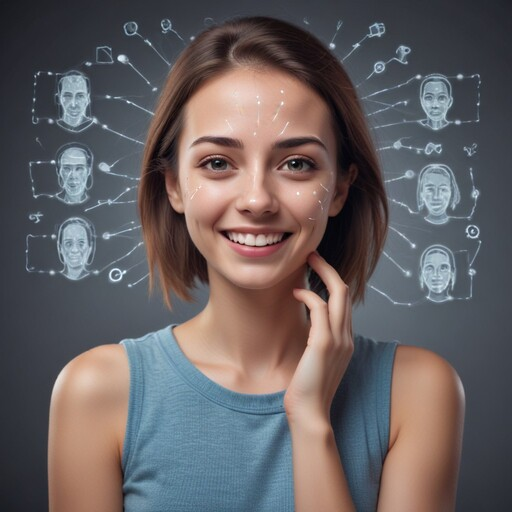

# Data collection

Data was collected directly from Kaggle , FER2013 dataset (Facial Expression Recognition 2013):
FER2013 is a dataset that consists of 35,887 labeled images depicting seven facial expressions -
anger, disgust, fear, happiness, sadness, surprise, and neutral.
It was created for the purposes of facial expression recognition research.

In [ ]:
import cv2
import os
!pip install imblearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import io
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from skimage.transform import rotate
from scipy.ndimage import rotate, shift
from skimage.transform import resize
!pip install mtcnn
from mtcnn import MTCNN
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import mode
import collections

The "create_dataframe" function facilitates the process of converting image data organized in directories into a structured and analyzable format, making it easier to work with FER2013 dataset in machine learning and data analysis

In [10]:
def create_dataframe(root_dir):
    # Define emotion labels and mapping
    emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    label_mapping = {emotion: index for index, emotion in enumerate(emotions)}

    data = []

    for emotion in emotions:
        emotion_dir = os.path.join(root_dir, emotion)

        # Load images for the current emotion
        for image_file in os.listdir(emotion_dir):
            image_path = os.path.join(emotion_dir, image_file)
            image = cv2.imread(image_path)


            data.append((image_path, label_mapping[emotion]))

    df = pd.DataFrame(data, columns=['image_path', 'label'])

    return df


Before proceeding with further analysis, let's take a quick look at the structure and contents of our training dataset by inspecting the first few rows using the "head()" method

In [83]:
train_dir = "/content/train"
test_dir = "/content/test"
train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)
train_df.head()
pixel_columns = [f"pixel_{i}" for i in range(48*48)]

In [12]:
#  Summary Statistics
train_summary = train_df.describe()
print("Train DataFrame Summary Statistics:")
print(train_summary)

Train DataFrame Summary Statistics:
              label
count  28709.000000
mean       3.317427
std        1.876632
min        0.000000
25%        2.000000
50%        3.000000
75%        5.000000
max        6.000000



**Summary Statistics :**

* The label column contains 28,709 entries.
*  The mean label value is approximately 3.32, indicating a balanced distribution across the different emotion categories.
* The standard deviation of the label values is approximately 1.88, indicating some variability in the distribution.
* The minimum label value is 0, and the maximum label value is 6, which corresponds to the range of emotion categories (angry, disgust, fear, happy, sad, surprise, neutral).

# EDA - Exploratory Data Analysis

Let's explore the distribution of classes (emotional expressions). Are they balanced or skewed?

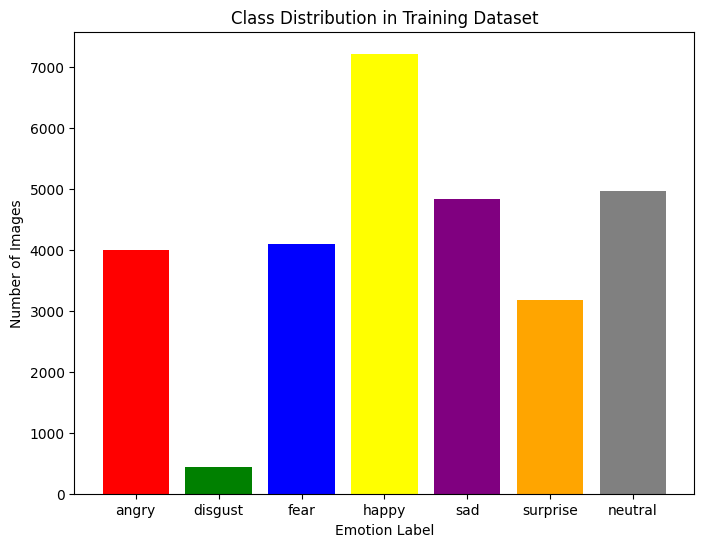

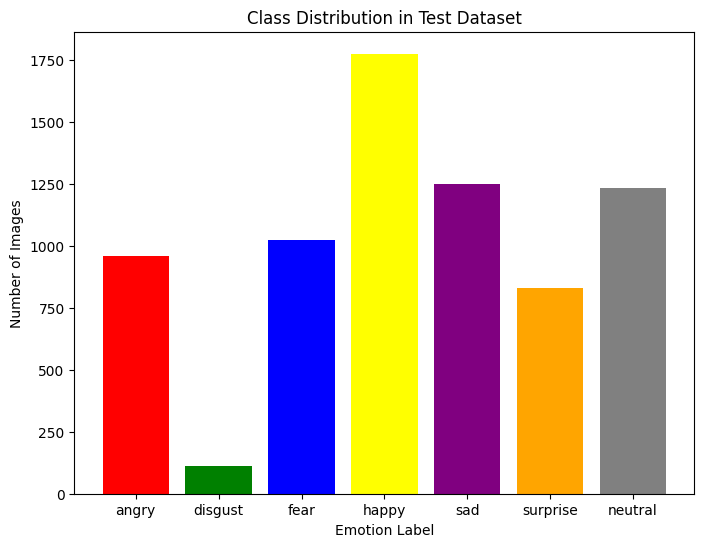

In [13]:
def plot_class_distribution(df, dataset_name):
    emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'gray']

    class_counts = df['label'].value_counts()
    plt.figure(figsize=(8, 6))
    plt.bar(class_counts.index, class_counts.values, color=[colors[label] for label in class_counts.index])
    plt.title(f'Class Distribution in {dataset_name}')
    plt.xlabel('Emotion Label')
    plt.ylabel('Number of Images')
    plt.xticks(list(range(len(emotions))), emotions)
    plt.show()

# Plot class distribution for training dataset
plot_class_distribution(train_df, 'Training Dataset')

# Plot class distribution for test dataset
plot_class_distribution(test_df, 'Test Dataset')

In our dataset, there is a noticeable imbalance, with a significantly larger number of samples representing one class compared to another. For instance, we observe 7215 samples associated with the "happy" class, while only 436 samples are attributed to the "disgusted" class. Such an imbalance can skew the learning process of our model, potentially leading to biased predictions favoring the majority class.






---
The following function gets a list of image paths as a parameter and returns a list where each element is a vector. This vector is a flattened representation of an image, each of which has a resolution of 48x48 pixels.


In [14]:
def load_and_preprocess_images(image_paths):
    images = []
    for path in image_paths:
        image = io.imread(path)
        images.append(image.flatten())
    return np.array(images)

# **Clustring**

In this part of the analysis, we aim to explore the potential of clustering techniques to uncover patterns and groupings within our facial emotion recognition dataset. Clustering is an unsupervised learning approach that partitions the data into distinct groups or clusters based on similarities among the data points.
By applying clustering to our dataset of flattened images, we can potentially identify natural groupings of facial expressions that may correspond to different emotional states. This approach can provide valuable insights into the underlying structure of the data and help us better understand the relationships between various emotional expressions.

In our analysis, we will be using the K-Means clustering algorithm, which is a widely used and well-established technique for partitioning data into distinct clusters. K-Means iteratively assigns data points to clusters based on their proximity to cluster centroids, with the goal of minimizing the sum of squared distances between data points and their assigned cluster centroids.
Before applying K-Means clustering, we will perform Principal Component Analysis (PCA) to reduce the dimensionality of our flattened image data. PCA is a linear transformation technique that projects the high-dimensional data onto a lower-dimensional subspace while preserving as much of the original variance as possible. This step is crucial for improving the computational efficiency of the clustering algorithm and potentially revealing underlying patterns that may be obscured in the original high-dimensional space.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


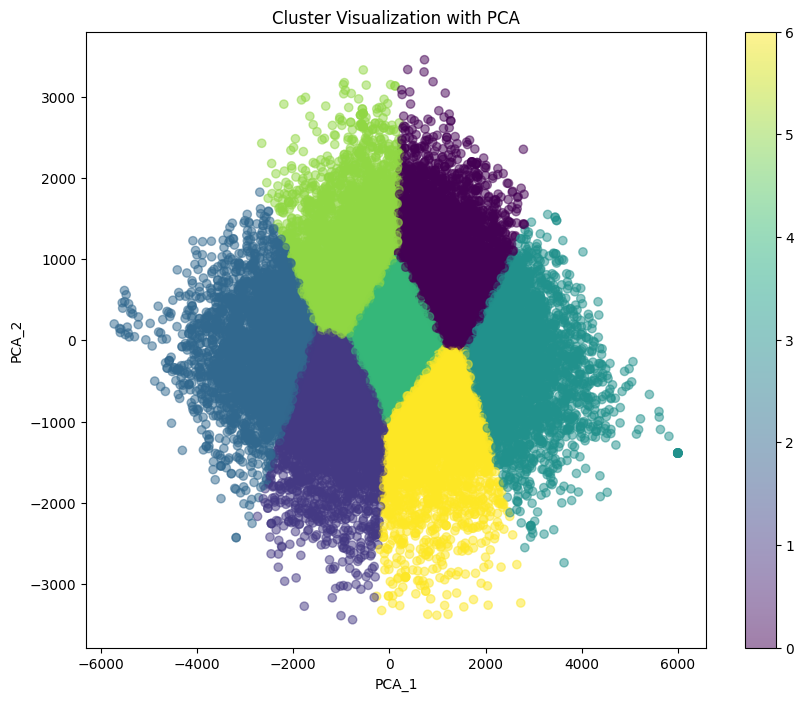

In [15]:


image_paths = train_df['image_path'].values
flattened_images = load_and_preprocess_images(image_paths)


pca = PCA(n_components=2)  # Adjust to 2 dimentions
images_reduced = pca.fit_transform(flattened_images)

# Apply K-means clustering
k = 7  # Suppose 7 clusters one for each emotion.
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(images_reduced)

# Plotting the results
plt.figure(figsize=(10, 8))
plt.scatter(images_reduced[:, 0], images_reduced[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.colorbar(ticks=range(k))
plt.title('Cluster Visualization with PCA')
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')
plt.show()

In [16]:
label_frequencies = collections.defaultdict(lambda: collections.defaultdict(int))

label_mapping = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'sad',
    5: 'surprise',
    6: 'neutral'
}
classes = train_df['label'].values #real labels

for data_idx, cluster in enumerate(clusters):
    label = classes[data_idx]
    label_frequencies[cluster][label] += 1
for key, value in label_frequencies.items():
  print(f"{key}: {value}")


for cluster, emotion in label_frequencies.items():
    max_emotion = max(emotion, key=emotion.get)
    print(f"For cluster emotion-dict {cluster}, the most common emotion is {label_mapping[max_emotion]}")

5: defaultdict(<class 'int'>, {0: 559, 1: 69, 2: 679, 3: 1184, 4: 527, 5: 626, 6: 705})
4: defaultdict(<class 'int'>, {0: 759, 1: 67, 2: 688, 3: 1393, 4: 920, 5: 449, 6: 873})
2: defaultdict(<class 'int'>, {0: 396, 1: 80, 2: 697, 3: 846, 4: 428, 5: 821, 6: 480})
1: defaultdict(<class 'int'>, {0: 649, 1: 60, 2: 746, 3: 870, 4: 642, 5: 603, 6: 617})
3: defaultdict(<class 'int'>, {0: 526, 1: 29, 2: 321, 3: 677, 4: 805, 5: 141, 6: 737})
0: defaultdict(<class 'int'>, {0: 562, 1: 78, 2: 504, 3: 1373, 4: 729, 5: 341, 6: 852})
6: defaultdict(<class 'int'>, {0: 544, 1: 53, 2: 462, 3: 872, 4: 779, 5: 190, 6: 701})
For cluster emotion-dict 5, the most common emotion is happy
For cluster emotion-dict 4, the most common emotion is happy
For cluster emotion-dict 2, the most common emotion is happy
For cluster emotion-dict 1, the most common emotion is happy
For cluster emotion-dict 3, the most common emotion is sad
For cluster emotion-dict 0, the most common emotion is happy
For cluster emotion-dict

After applying the K-Means clustering algorithm and conducting dimensionality reduction through Principal Component Analysis (PCA), our objective was to assess the alignment between the clusters formed and the actual emotion categories represented in the data. Despite K-Means being an unsupervised learning method, the availability of true emotion labels in our dataset allowed for a unique validation opportunity. We aimed to determine if each cluster corresponded to one predominant emotion, thereby assessing the effectiveness of our clustering approach.

The analysis consistently showed that the dominant emotion across almost all clusters was "happy". This outcome raises a couple of crucial points regarding both the data and the methodological approach:

Imbalanced Dataset: The data may exhibit a substantial skew towards "happy" emotion images. Such an imbalance can heavily influence the clustering process, resulting in most clusters predominantly reflecting the "happy" emotion due to its higher prevalence.

Algorithmic Limitations: The consistent dominance of the "happy" emotion across various algorithmic trials suggests that the K-Means algorithm, along with the PCA setup used, may not be adequately capturing the subtle differences between diverse emotion categories. This could be due to the inherent limitations of K-Means in dealing with complex and nuanced data structures typically found in emotion recognition tasks.

**Note:** Efforts were made to refine the analysis by employing various clustering algorithms and adjusting the PCA parameters. Despite these modifications, the dominance of the "happy" emotion persisted across all tested configurations. Therefore, these variations were not included in the  as they did not yield distinct results or insights.



---

Let's verify if our database includes any duplicate entries.







In [17]:
image_paths = train_df['image_path'].values
X = load_and_preprocess_images(image_paths)
# Find unique rows in X
unique_X, unique_indices = np.unique(X, axis=0, return_index=True)

print(len(unique_indices))
print(len(X))

# Check if there are duplicates
if len(unique_indices) == len(X):
    print("No duplicates found in X.")
else:
    print("Duplicates found in X.")

27473
28709
Duplicates found in X.


In [18]:
y = train_df['label'].values

The analysis reveals that there are 618 duplicated samples, calculated as half the difference between the total number of samples (28709) and the number of unique samples (27473). Next, we'll examine the classes of these duplicated samples. Based on the distribution of classes among the duplicates, we'll make an informed decision on whether to retain or remove them

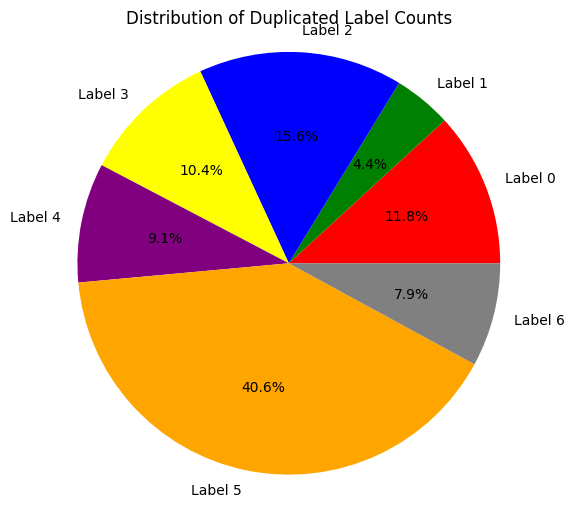

In [19]:
# Calculate the indices of duplicates
duplicated_indices = set(range(len(X))) - set(unique_indices)

# Extract the labels of duplicated samples
duplicated_labels = y[list(duplicated_indices)]

label_counts = np.bincount(duplicated_labels)

# Print the label counts
#for label, count in enumerate(label_counts):
    #print(f"Number of {label}s in duplicated_labels: {count}")

colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'gray']
labels = [f"Label {i}" for i in range(len(label_counts))]

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=labels, colors=colors[:len(label_counts)], autopct='%1.1f%%')
plt.title('Distribution of Duplicated Label Counts')
plt.axis('equal')
plt.show()


We've chosen not to delete the duplicate entries in the data for several  reasons :


*   **Class Imbalance :** Since most of the duplicates belong to class 5 (surprised face), which is not the dominant class and might need additional data for balance in the future, retaining the duplicates maintains a certain level of representation for this class. This approach aligns with the future plan of balancing categories and creating new data.
*   **Small Percentage of Duplicates:** The number of duplicates (618) relative to the total number of samples (28709) is relatively small 618/28709 = 0.021 , representing only a fraction of the dataset. Therefore, the impact of these duplicates on data quality and model performance is likely to be minimal.



---




let's visualize some sample images from different classes to get an idea of the data.

In [20]:
def display_sample_images(df, num_classes=7, num_samples_per_class=5):
    emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    fig, axes = plt.subplots(num_classes, num_samples_per_class, figsize=(15, 15))

    for i, emotion in enumerate(emotions):
        # Filter DataFrame for images belonging to the current emotion class
        emotion_images = df[df['label'] == i].sample(num_samples_per_class)['image_path'].values

        for j, image_path in enumerate(emotion_images):
            image = cv2.imread(image_path)
            axes[i, j].imshow(image)
            axes[i, j].set_title(emotion)
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()


Each row represents a different emotion class.
* emotion labels are provided as titles for each image.

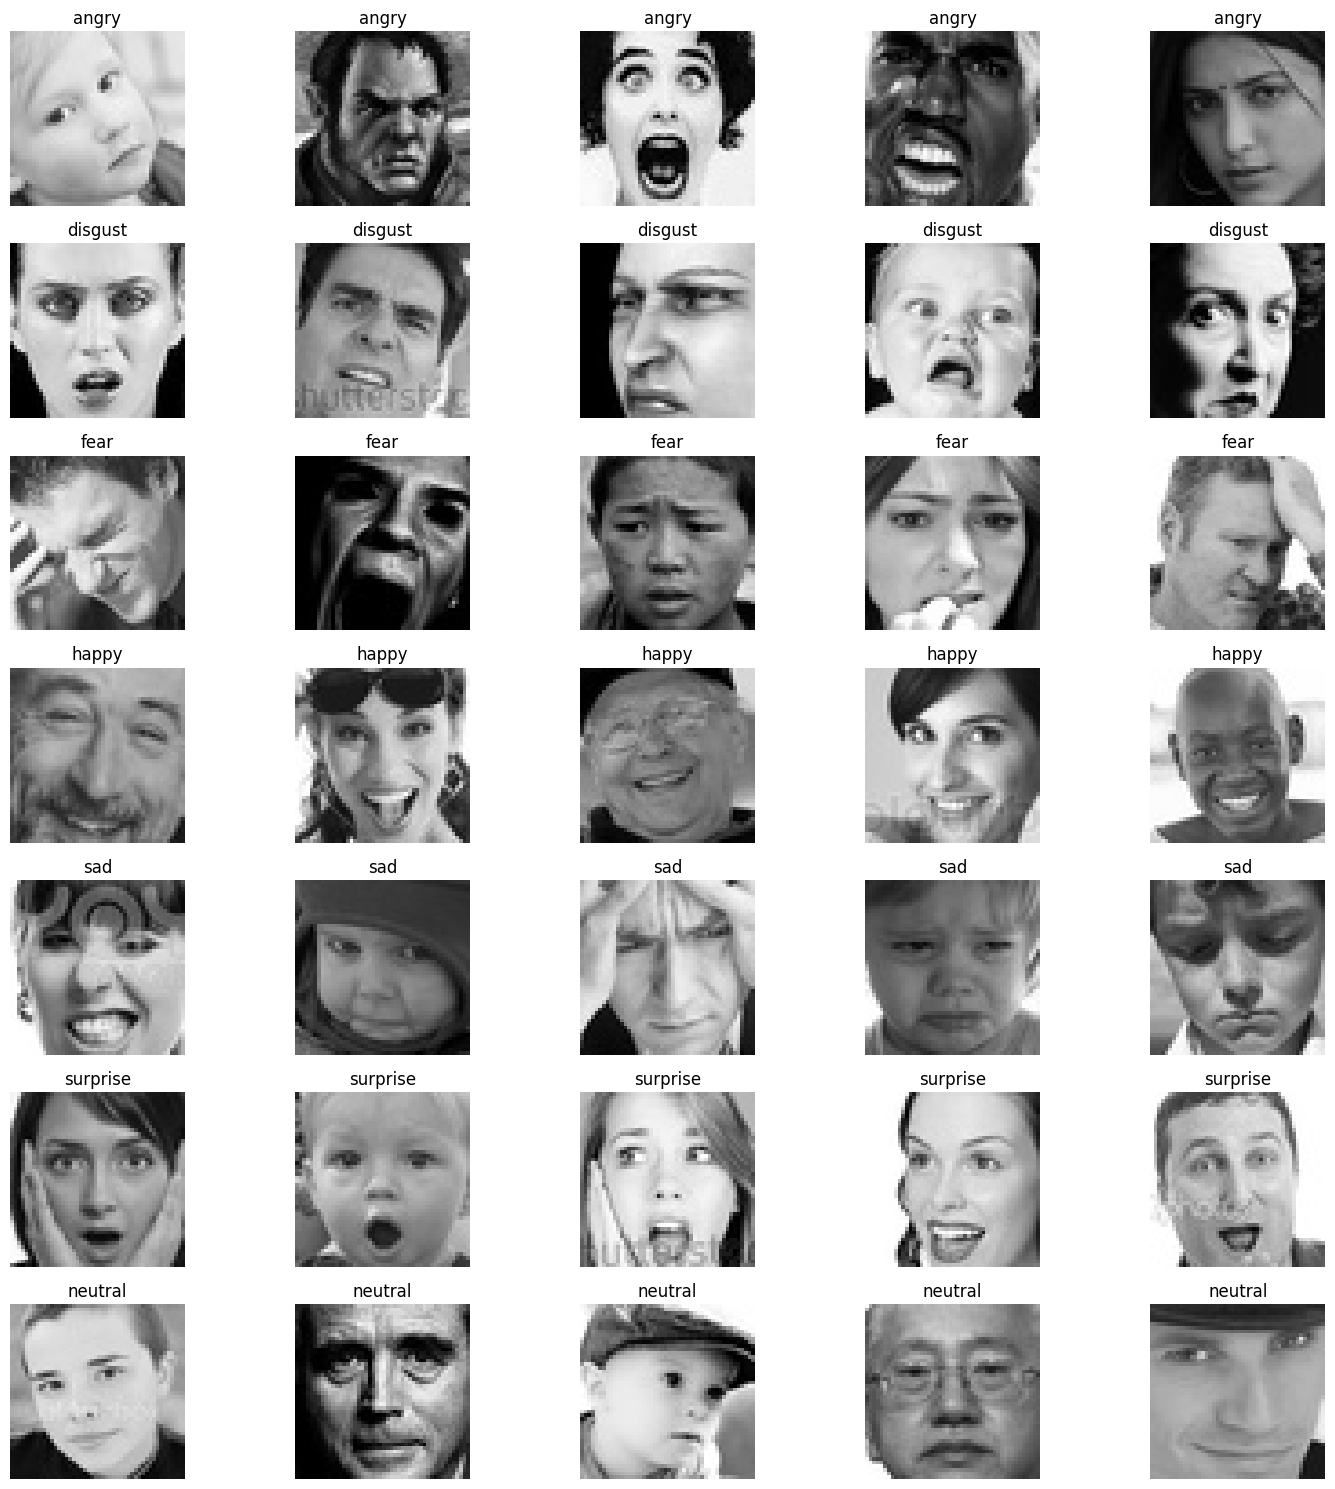

In [21]:
display_sample_images(train_df)


---


To address the class imbalance problem , we intend to employ a  technique known as Synthetic Minority Over-sampling Technique (SMOTE) . SMOTE works by generating synthetic samples in the minority class, thus equalizing the representation of both classes. This helps to alleviate the class imbalance problem by artificially increasing the number of minority class samples.



In [22]:
# Load and preprocess images
image_paths = train_df['image_path'].values
X = load_and_preprocess_images(image_paths)
y = train_df['label'].values

# Apply SMOTE to balance the dataset
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)
print(len(X_resampled))
print(len(y_resampled))

# Combine resampled features and labels
preprocess_train_df = pd.DataFrame(X_resampled, columns=[f"pixel_{i}" for i in range(X_resampled.shape[1])])
preprocess_train_df['label'] = y_resampled


# Check the class distribution after resampling
print("Class distribution after resampling:")
print(preprocess_train_df['label'].value_counts())

50505
50505
Class distribution after resampling:
label
0    7215
1    7215
2    7215
3    7215
4    7215
5    7215
6    7215
Name: count, dtype: int64


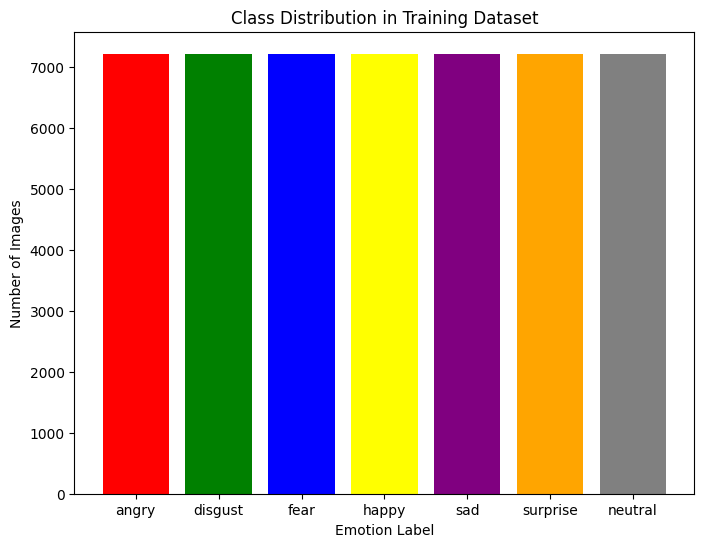

In [23]:
plot_class_distribution(preprocess_train_df, 'Training Dataset')

Let's visualize a selection of sample images from various classes within the dataset after applying the SMOTE algorithm to balance it, thereby assessing the quality of the balanced dataset.

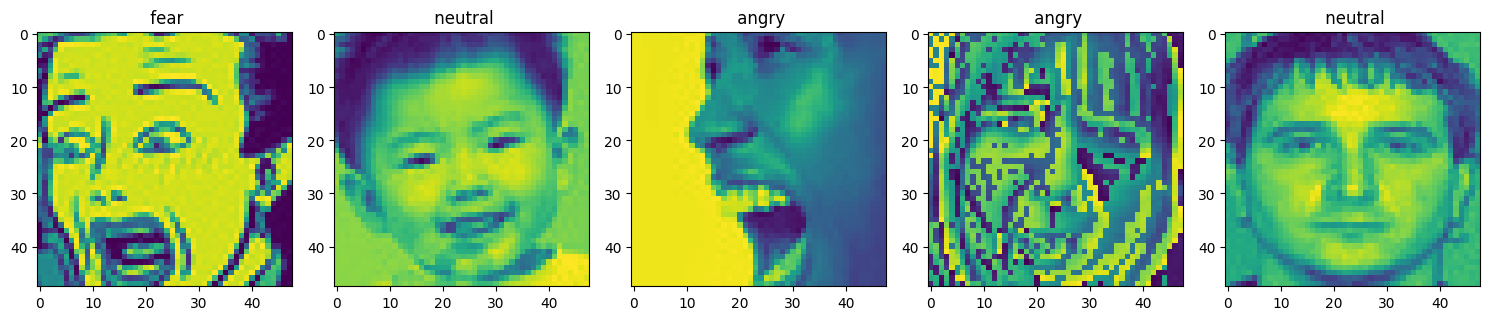

In [24]:
num_samples_to_display = 5
emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Randomly select some sample indices
sample_indices = np.random.choice(preprocess_train_df.shape[0], num_samples_to_display, replace=False)

# Create a subplot grid
fig, axes = plt.subplots(1, num_samples_to_display, figsize=(15, 3))

for i, idx in enumerate(sample_indices):
    image_data = preprocess_train_df.iloc[idx, :-1].values.reshape(48, 48)
    label = preprocess_train_df.iloc[idx, -1]
    axes[i].imshow(image_data)
    axes[i].set_title(f" {emotions[label]}")

plt.tight_layout()
plt.show()

We made several iterations of this section, Upon careful examination of the facial images, it became evident that certain newly generated images exhibited noise, characterized by inconsistencies in certain pixels. This outcome was anticipated due to the application of SMOTE, which can introduce noise in generated samples. Nevertheless, it is noteworthy that a notable correlation persists between the newly created samples and their respective emotion classifications.


* **Importance of Landmark Detection for Face Alignment in our Dataset**

Landmark detection refers to the identification of key points on a face, such as the corners of the eyes, nose and mouth corners.
Aligning faces based on these landmarks is crucial for standardizing facial orientations and positions, thereby enhancing the accuracy of emotion recognition.

In [25]:
def detect_landmarks(image):
    # Create MTCNN detector
    detector = MTCNN()

    # Convert grayscale image to RGB by stacking along the third axis
    image_rgb = np.stack((image,) * 3, axis=-1).astype(np.uint8)

    # Detect faces in the image
    faces = detector.detect_faces(image_rgb)

    if len(faces) == 1:
        face = faces[0]['box']  # Extract the bounding box of the face
        landmarks_points = []

        # Assuming MTCNN detects landmarks as well
        landmarks = faces[0]['keypoints']

        # Extract facial landmarks
        for key, value in landmarks.items():
            landmarks_points.append(value)

        return np.array(landmarks_points, dtype=int)

    elif len(faces) == 0:
        print("No faces detected")

    else:
        print("Multiple faces detected, unable to process")

    return None


---


Now we will implement align_face function!

In [26]:
# Function to align a face represented by a vector
def align_face(image_vector, width, height):

    image_array = np.reshape(image_vector, (height, width))

    # Detect facial landmarks
    landmarks = detect_landmarks(image_array)

    if landmarks is None:
        print("No face detected")
        return image_vector

    # Extract facial landmarks
    left_eye = landmarks[0]
    right_eye = landmarks[1]
    nose = landmarks[2]
    mouth_left = landmarks[3]
    mouth_right = landmarks[4]

    # Calculate angle between eyes
    angle = np.arctan2(right_eye[1] - left_eye[1], right_eye[0] - left_eye[0]) * 180 / np.pi

    # Calculate the midpoint between the eyes
    eye_midpoint = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)

    # Calculate the midpoint between the mouth edges
    mouth_midpoint = ((mouth_left[0] + mouth_right[0]) // 2, (mouth_left[1] + mouth_right[1]) // 2)

    # Calculate the distance between the eyes
    eye_distance = np.sqrt((right_eye[0] - left_eye[0]) ** 2 + (right_eye[1] - left_eye[1]) ** 2)

    # Define the desired eye distance in the aligned face
    desired_eye_distance = 0.4 * width

    # Calculate scale factor
    scale = desired_eye_distance / eye_distance

    # Calculate translation to center the face
    translate_x = width // 2 - eye_midpoint[0]
    translate_y = height // 2 - (eye_midpoint[1] + mouth_midpoint[1]) // 2

    # Apply transformations to align face
    aligned_face = rotate(image_array, angle)
    aligned_face = shift(aligned_face, (translate_y, translate_x))
    aligned_face = resize(aligned_face, (height, width))

    return np.reshape(aligned_face, -1)

Let's visualize the images returned by the detect_marks_landmarks function on several images in our dataset to validate the algorithm's succes

1/1 [==============================] - 0s 348ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 249ms/step


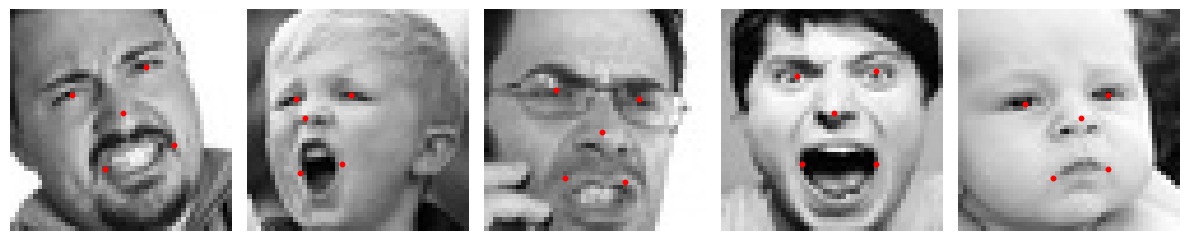

In [27]:
def show_image(image_vector, landmarks=None):
    image = image_vector.reshape(48, 48)
    plt.imshow(image, cmap='gray')
    if landmarks:
        for (x, y) in landmarks:
            plt.scatter(x, y, c='red', s=10)
    plt.axis('off')

def display_images_with_landmarks_in_grid(df, pixel_columns, rows=1, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 3))

    for i in range(rows * cols):
        image_vector = df.iloc[i][pixel_columns].values
        aligned_landmarks = detect_landmarks(np.reshape(image_vector, (48, 48)))

        ax = axes[i]
        ax.imshow(np.reshape(image_vector, (48, 48)), cmap='gray')
        for (x, y) in aligned_landmarks:
            ax.scatter(x, y, c='red', s=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

display_images_with_landmarks_in_grid(preprocess_train_df, pixel_columns, rows=1, cols=5)

**Amazing !**
The success of the algorithm in scoring the areas within the face images, including the eyes, nose, and mouth, is evident from the analysis. Notably, the algorithm demonstrated its efficacy even in identifying these areas in "half faces," where facial features are partially obscured or moved from their typical positions.

For instance, upon examining the fourth sample provided, it becomes apparent that the algorithm accurately pinpointed the relevant areas despite the partial visibility of the facial features. This capability underscores the robustness and adaptability of the algorithm in handling variations in facial orientation and expression.

The align_face function aims to align the detected face within the image vector. By detecting facial landmarks , the function calculates the necessary transformations to align the face properly. This includes determining the angle of rotation needed to orient the face correctly and calculating the translation required to center the face within the image vector. Additionally, the function resizes the face to ensure a consistent eye distance.

-----------------------------------------------------------------------
Let's take a moment to review a selection of images post face alignment, offering insight into the quality of our model and the efficacy of our face alignment efforts. This serves as a valuable gauge of our success in this task.

1/1 [==============================] - 0s 132ms/step


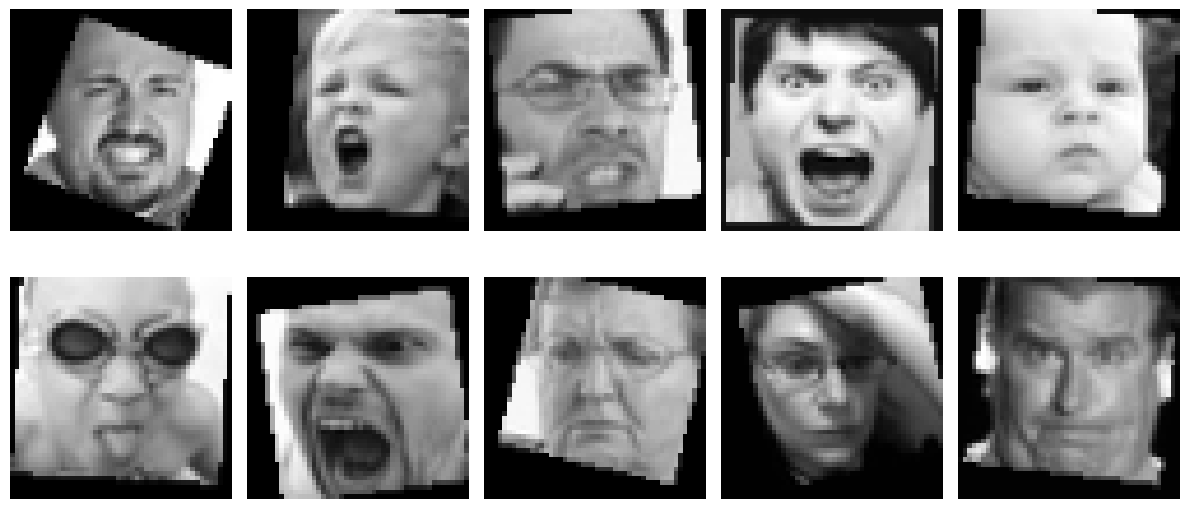

In [28]:
def display_images_in_grid(df, pixel_columns, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6))

    for i in range(rows * cols):
        image_vector = df.iloc[i][pixel_columns].values
        aligned_face = align_face(image_vector, 48, 48)
        image = aligned_face.reshape(48, 48)

        ax = axes[i // cols, i % cols]
        ax.imshow(image, cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

pixel_columns = [f"pixel_{i}" for i in range(48*48)]
display_images_in_grid(preprocess_train_df, pixel_columns, rows=2, cols=5)


Our visual analysis indicates that the algorithm was unable to achieve success in the facial alignment task. This task is complex, and currently, there is no readily available model that can be directly utilized for this purpose.
in the other hand the algorithm effectively placed the eyes of each face at consistent coordinates within the images, demonstrating precise pixel positioning.

Moving forward, our approach will involve constructing models using datasets both with and without face alignment. We anticipate comparable outcomes between the two, as the fundamental change brought about by alignment appears minimal. However, we lean towards the notion that utilizing data post-alignment may yield better results. The consistent pixel placement of the eyes across a significant portion of images simplifies the task for the network, enhancing its ability to discern facial expressions effectively.







In [ ]:
#import relevant libraries
import keras
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
import tensorflow as tf
from skimage.color import gray2rgb
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import f1_score
from keras.utils import plot_model
from joblib import Parallel, delayed
from collections import Counter
!pip install pydot
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import pydot
from sklearn import svm
from skimage.feature import hog
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB


In this section, we will train a Multinomial Naive Bayes (MNB) classifier on the FER2013 dataset after applying SMOTE on it .
 Multinomial Naive Bayes is a probabilistic classifier based on Bayes' theorem and is particularly suited for discrete data

In [30]:
X = preprocess_train_df.drop('label', axis=1).values
y = preprocess_train_df['label'].values

 To enhance the performance of our classifier, we will use Histogram of Oriented Gradients (HOG) features, which are effective in capturing the edge and gradient structure of images , Using HOG features not only enhances the performance of the classifier by capturing essential facial characteristics but also significantly reduces the computational cost. When we initially tried running the algorithm without HOG, the training and prediction times were substantially longer due to the higher dimensionality of raw pixel data

In [31]:
def extract_hog_features(images):
    hog_features = []
    for image in images:
        fd = hog(image.reshape((48, 48)), orientations=9, pixels_per_cell=(8, 8),
                 cells_per_block=(2, 2), visualize=False, transform_sqrt=True, block_norm='L1')
        hog_features.append(fd)
    return np.array(hog_features)

In [32]:
hog_features = extract_hog_features(X)


In [33]:
def preprocess_test_data2(df):
    images_array = []
    labels = df['label'].values
    num_classes = 7

    labels_one_hot = np.eye(num_classes)[labels]

    for image_path in df['image_path']:
        image = cv2.imread(image_path)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray_image = gray_image.astype('float32') / 255.0
        images_array.append(gray_image)

    return np.array(images_array), labels_one_hot

In [34]:
X_test , y_test= preprocess_test_data2(test_df)
X_test_hog = extract_hog_features(X_test)

Now, it's time to train our classifier and make predictions on the validation set.

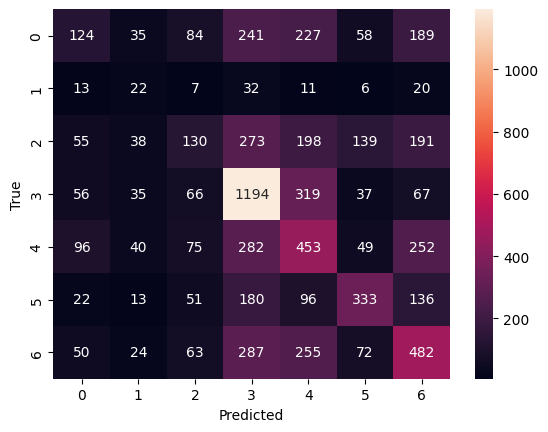

Accuracy: 0.38144329896907214


In [35]:
clf = MultinomialNB()
clf.fit(hog_features, y)
y_pred = clf.predict(X_test_hog)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_df['label'].unique(), yticklabels=test_df['label'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print(f'Accuracy: {accuracy_score(y_test.argmax(axis=1), y_pred)}')


After training the Multinomial Naive Bayes model, we achieved an accuracy of 38.23% on the validation set. However, we aim to further improve the accuracy of our classifier. To achieve this, we will leverage two powerful techniques: Histogram of Oriented Gradients (HOG) for feature extraction and Support Vector Machine (SVM) for classification.


---



SVM aims to find the optimal hyperplane that best separates the data points of different classes in a high-dimensional space. The optimal hyperplane maximizes the margin between the closest points (support vectors) of different classes ,
and HOG captures the structure or the shape of an object by counting occurrences of gradient orientation in localized portions of an image.

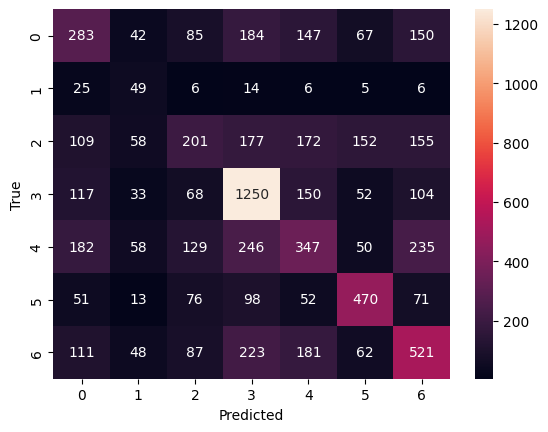

Accuracy: 0.4348007801616049


In [36]:
# Train the SVM on the HOG features
clf = svm.SVC(kernel='linear', C=1.0)
clf.fit(hog_features, y)
y_pred = clf.predict(X_test_hog)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred)

sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_df['label'].unique(), yticklabels=test_df['label'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(f'Accuracy: {accuracy_score(y_test.argmax(axis=1), y_pred)}')



This approach improved our accuracy to 43.81%.

we can see that :

The accuracy along the main diagonal (correct predictions) has increased for most classes.

The improvement in accuracy indicates that HOG features combined with the SVM classifier have significantly enhanced our model's ability to correctly classify different emotions.

However, one exception is department 5, where the accuracy did not improve and might have even slightly decreased.


---



to achieve even better performance, we will now explore a more complex and powerful model: **ResNet-50**.

Before diving into model training, it's crucial to preprocess our data effectively to ensure optimal representation for the neural network. This preparation phase lays the foundation for successful training by transforming data into a format that the network can effectively learn from.


In [37]:
target_size = (224, 224)  # ResNet50 input size
def preprocess_train_data(preprocess_train_df, pixel_columns,flag = False):
    # Step 1: Reshape the image vectors into 48x48 pixel images
    image_size = (48, 48)
    images = []
    for i in range(len(preprocess_train_df)):
        if flag == False :
          image_vector = preprocess_train_df.iloc[i][pixel_columns].values
        else :
          image_vector = preprocess_train_df.iloc[i]['Aligned Images']
        image_array = np.reshape(image_vector, image_size)

        images.append(image_array)

    # Step 2: Convert images to array format
    images_array = np.array(images, dtype=np.float32)
    images_array = np.expand_dims(images_array, axis=-1)  # Add channel dimension

    # Step 3: Normalization
    #images_array = images_array / 255.0

    # Step 4: Extract labels
    labels = preprocess_train_df.iloc[:, -1].values

    # Step 5: Apply one-hot encoding to labels
    encoder = OneHotEncoder(sparse=False, categories='auto')
    labels_one_hot = encoder.fit_transform(labels.reshape(-1, 1))

    return images_array, labels_one_hot


In [38]:
def preprocess_image(x):
    # Repeat the grayscale channel to simulate RGB
    rgb_image = tf.repeat(x, 3, axis=-1)
    return rgb_image

datagen = ImageDataGenerator(
    rescale=1./255,
    #preprocessing_function=preprocess_image  # Convert to RGB
)

In [39]:
pixel_columns = [f"pixel_{i}" for i in range(48*48)]
X_train, y_train = preprocess_train_data(preprocess_train_df, pixel_columns)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


The ResNet model receives RGB images, so we will use convert_grayscale_to_rgb to convert the images in our data to fit the model

In [40]:
def convert_grayscale_to_rgb(img):
  img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  return img_rgb

In [41]:
X_train_rgb = np.array([convert_grayscale_to_rgb(img) for img in X_train])

We chose a batch size of 32 because using a larger batch size exceeded our memory capacity.

In [42]:
BATCH_SIZE = 32
STEPS_PER_EPOCH = np.ceil(len(preprocess_train_df) / BATCH_SIZE)

In [43]:

train_generator = datagen.flow(X_train_rgb, y_train, batch_size=32)

Now let's build a neural network model and utilize the ResNet50 architecture. The model consists of an input layer with an input shape of (48, 48, 3), indicating three channels for RGB images. It then utilizes a pre-trained ResNet50 model (excluding the top layer) with weights initialized from ImageNet. This is followed by a Global Average Pooling 2D layer to reduce spatial dimensions, and finally, a Dense layer with softmax activation, outputting probabilities for each of the seven categories. The model is compiled using the Adam optimizer with a categorical cross-entropy loss function and accuracy as the evaluation metric

In [44]:
def build_and_compile_model():
    NUM_CATEGORIES = 7


    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(48, 48, 3)),
        tf.keras.applications.ResNet50(include_top=False, weights="imagenet"),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(NUM_CATEGORIES, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [45]:
model = build_and_compile_model()
model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_105 (Dense)           (None, 7)                 14343     
                                                                 
Total params: 23602055 (90.03 MB)
Trainable params: 23548935 (89.83 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [46]:
def preprocess_test_data(df, target_size=(224, 224)):
    images_array = []
    labels = df['label'].values
    num_classes = 7

    # Convert labels to one-hot encoded format
    labels_one_hot = np.eye(num_classes)[labels]

    for image_path in df['image_path']:
        image = cv2.imread(image_path)
        # Resize image to fit ResNet50 input size
        #image = cv2.resize(image, target_size)
        # Convert image to RGB if it's grayscale
        #if len(image.shape) == 2:
            #image = gray2rgb(image)
        image = image.astype('float32') / 255.0  # Normalize pixel values

        images_array.append(image)

    return np.array(images_array), labels_one_hot

let's visualize the model architecture as a diagram

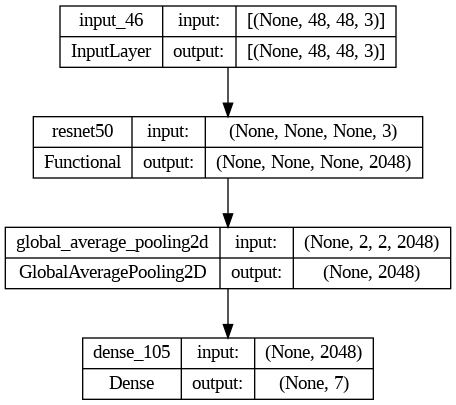

In [47]:
plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)


-The None values indicate that these dimensions can be of any size

In [48]:
test_images, test_labels = preprocess_test_data(test_df,pixel_columns)
test_generator = datagen.flow(test_images, test_labels, batch_size=32)
history = model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
1579/1579 [==============================] - 102s 44ms/step - loss: 1.4396 - accuracy: 0.4673 - val_loss: 1.9286 - val_accuracy: 0.1737
Epoch 2/10
1579/1579 [==============================] - 65s 41ms/step - loss: 1.1663 - accuracy: 0.5628 - val_loss: 2.0265 - val_accuracy: 0.1771
Epoch 3/10
1579/1579 [==============================] - 65s 41ms/step - loss: 1.0419 - accuracy: 0.6103 - val_loss: 2.3524 - val_accuracy: 0.1335
Epoch 4/10
1579/1579 [==============================] - 66s 42ms/step - loss: 0.9532 - accuracy: 0.6476 - val_loss: 2.3607 - val_accuracy: 0.1737
Epoch 5/10
1579/1579 [==============================] - 65s 41ms/step - loss: 0.8358 - accuracy: 0.6924 - val_loss: 2.3189 - val_accuracy: 0.1335
Epoch 6/10
1579/1579 [==============================] - 65s 41ms/step - loss: 0.8340 - accuracy: 0.6971 - val_loss: 3.5140 - val_accuracy: 0.1335
Epoch 7/10
1579/1579 [==============================] - 65s 41ms/step - loss: 0.6275 - accuracy: 0.7710 - val_loss: 4.5933 

To understand the performance of our model during training, we will plot the accuracy and loss for both the training and validation sets after each epoch. These plots will help us observe how well our model is learning and generalizing.

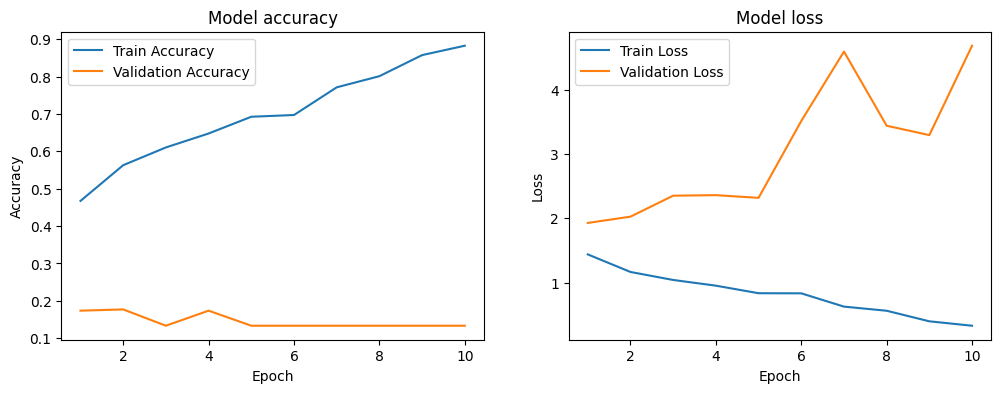

In [49]:
epochs = np.arange(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Train Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

After analyzing the training and validation accuracy and loss curves, we decided to use 5 epochs for training our model. This decision was based on the following observations:

**Maximized Accuracy:** The accuracy for both training and validation sets improves during the first 5 epochs

**Minimized Loss:** The loss for both training and validation sets decreases  during the first 5 epochs and begins to level off

**Overfitting:** By limiting the number of epochs to 5, we aim to reduce the risk of overfitting, where the model might perform well on the training data but poorly on unseen validation data.

--------------------------------------------------------------------------------
Now we will investigate the impact of fine-tuning the layers of the ResNet50 model. Initially, we will set layer.trainable = False for the ResNet50 layers, effectively freezing them, meaning that their weights will not be updated during training. We'll then observe the model's performance. Subsequently, we will set layer.trainable = True for the ResNet50 layers, allowing them to be trained along with the additional layers we've added. This process, known as fine-tuning, enables the model to adapt more specifically to our dataset. By comparing the performance before and after fine-tuning, we can assess the effectiveness of this technique in improving the model's performance

In [50]:
model = build_and_compile_model()
# Freeze the ResNet50 layers
for layer in model.layers:
    if layer.name.startswith('resnet50'):
        layer.trainable = False

history = model.fit(train_generator, epochs=5)


Epoch 1/5
1579/1579 [==============================] - 94s 41ms/step - loss: 1.4951 - accuracy: 0.4488
Epoch 2/5
1579/1579 [==============================] - 65s 41ms/step - loss: 1.2204 - accuracy: 0.5438
Epoch 3/5
1579/1579 [==============================] - 64s 40ms/step - loss: 1.0853 - accuracy: 0.5941
Epoch 4/5
1579/1579 [==============================] - 63s 40ms/step - loss: 0.9930 - accuracy: 0.6288
Epoch 5/5
1579/1579 [==============================] - 63s 40ms/step - loss: 0.8891 - accuracy: 0.6722


In [51]:

NUM_CATEGORIES = 7

model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(48, 48, 3)),
        tf.keras.applications.ResNet50(include_top=False, weights="imagenet"),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(NUM_CATEGORIES, activation="softmax")
    ])

# Unfreeze the ResNet50 layers
for layer in model.layers:
    if layer.name.startswith('resnet50'):
        layer.trainable = True

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(train_generator, epochs=5)


Epoch 1/5
1579/1579 [==============================] - 92s 41ms/step - loss: 1.5356 - accuracy: 0.4411
Epoch 2/5
1579/1579 [==============================] - 65s 41ms/step - loss: 1.2866 - accuracy: 0.5237
Epoch 3/5
1579/1579 [==============================] - 65s 41ms/step - loss: 1.1595 - accuracy: 0.5689
Epoch 4/5
1579/1579 [==============================] - 65s 41ms/step - loss: 1.0073 - accuracy: 0.6211
Epoch 5/5
1579/1579 [==============================] - 65s 41ms/step - loss: 0.8852 - accuracy: 0.6696


We achieved lower accuracy compared to the trained ResNet network  as we expected, but the difference is not significant.




In [52]:
# Fit the model using the generator
#model.fit(train_generator, epochs=5)

In [53]:
len(preprocess_test_data(test_df)[0][0])


48

let's evaluate our model

In [54]:
test_images, test_labels = preprocess_test_data(test_df)

In [55]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_images, test_labels)

print("Test Accuracy:", accuracy)


225/225 [==============================] - 3s 7ms/step - loss: 1.2786 - accuracy: 0.5337
Test Accuracy: 0.5337141156196594


In [56]:
def plot_confusion_matrix(model, test_images, test_labels):
    predictions = model.predict(test_images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    confusion_matrix = tf.math.confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


225/225 [==============================] - 2s 6ms/step


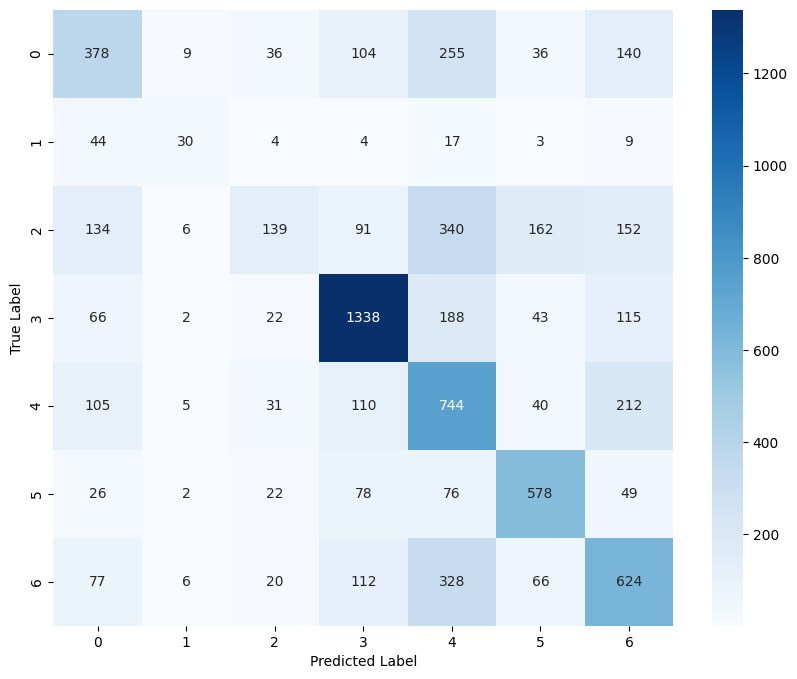

In [57]:
plot_confusion_matrix(model, test_images, test_labels)

We can see that in each row of the confusion matrix, the largest number is on the main diagonal. This means that for each category, the model most frequently classifies the images into the correct category.

In addition, we can see that for the emotion "happy," we received hight accuracy. This may be because the training dataset has the most samples belonging to the "happy" class, providing better diversity compared to the diversity we artificially created using SMOTE. Later, we will examine another method for balancing the data.

Surprisingly 😯, we got the highest accuracy (713/831 = 0.85) in the emotion "surprised."  even though it is second to last in terms of the number of samples in the original database.

225/225 [==============================] - 1s 6ms/step
Precision: [0.45542169 0.5        0.50729927 0.72836146 0.38193018 0.62284483
 0.47963105]
Recall: [0.39457203 0.27027027 0.13574219 0.75422773 0.59663192 0.69554753
 0.50608273]
F1-score: [0.42281879 0.35087719 0.21417565 0.74106896 0.4657277  0.65719159
 0.49250197]


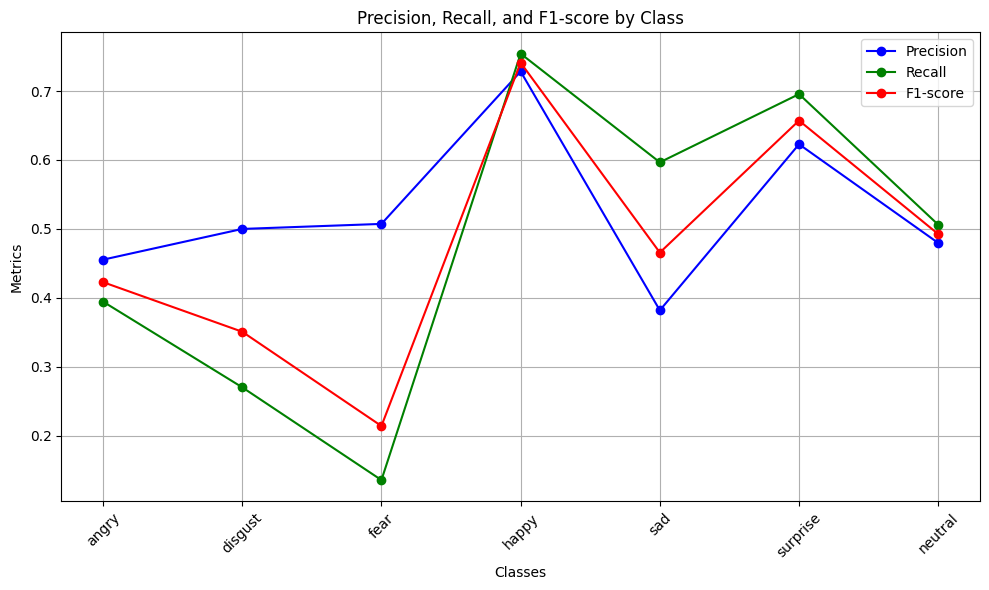

In [58]:
emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
predictions = model.predict(test_images)
true_labels = np.argmax(test_labels, axis=1)
predicted_labels = np.argmax(predictions, axis=1)

precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1_score = f1_score(true_labels, predicted_labels, average=None)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)
plt.figure(figsize=(10, 6))

plt.plot(emotions, precision, marker='o', label='Precision', color='blue')
plt.plot(emotions, recall, marker='o', label='Recall', color='green')
plt.plot(emotions, f1_score, marker='o', label='F1-score', color='red')

plt.title('Precision, Recall, and F1-score by Class')
plt.xlabel('Classes')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

# Align Faces

Insted of making our model smarter , can we make the task easier ?



---

Now we will align the faces using the function 'align_face' on the dataset after applying SMOTE algorithm ,hoping to see any  improvments


In [59]:
def process_data_chunk(chunk_df, pixel_columns):
    aligned_images = []
    labels = []

    for j in range(len(chunk_df)):
        image_vector = chunk_df.iloc[j][pixel_columns].values
        aligned_face = align_face(image_vector, 48, 48)
        aligned_images.append(aligned_face)

    aligned_images_array = np.array(aligned_images)
    labels_one_hot = chunk_df.iloc[:, -1].values

    return pd.DataFrame({ 'Aligned Images': aligned_images_array.tolist(), 'Labels': labels_one_hot.tolist() })

def process_data_in_chunks(preprocess_train_df, pixel_columns, chunk_size=500):
    processed_chunks = []

    for i in range(0, len(preprocess_train_df), chunk_size):
        chunk_df = preprocess_train_df[i:i + chunk_size]
        processed_chunk = process_data_chunk(chunk_df, pixel_columns)
        processed_chunks.append(processed_chunk)

    # Concatenate processed chunks into a single DataFrame
    processed_data_df = pd.concat(processed_chunks, ignore_index=True)

    return processed_data_df



Processing the entire dataset without chunking would exceed our memory capacity. By dividing the data into smaller chunks, we can handle it more efficiently. Additionally, parallel processing significantly speeds up the process. Without parallelization, the processing would take approximately 10 hours, whereas using parallel processing reduces this time substantially.



In [60]:
def process_data_chunk_parallel(chunk_df, pixel_columns):
    def process_row(row, pixel_columns):
        image_vector = row[pixel_columns].values
        aligned_face = align_face(image_vector, 48, 48)
        return aligned_face.tolist(), row.iloc[-1]

    processed_data = Parallel(n_jobs=-1)(delayed(process_row)(row, pixel_columns) for _, row in chunk_df.iterrows())
    aligned_images, labels = zip(*processed_data)

    return pd.DataFrame({'Aligned Images': aligned_images, 'Labels': labels})

def process_data_in_chunks_parallel(preprocess_train_df, pixel_columns, chunk_size=500):
    processed_chunks = []

    for i in range(0, len(preprocess_train_df), chunk_size):
        chunk_df = preprocess_train_df[i:i + chunk_size]
        processed_chunk = process_data_chunk_parallel(chunk_df, pixel_columns)
        processed_chunks.append(processed_chunk)

    processed_data_df = pd.concat(processed_chunks, ignore_index=True)

    return processed_data_df


In [ ]:

aligned_df = process_data_in_chunks_parallel(preprocess_train_df, pixel_columns)

Adjusting the shape of the base to enable the execution of the extract_hog_features function.

In [ ]:
aligned_df2 = aligned_df
for i in range(48*48):
    aligned_df2[f'pixel_{i}'] = [row[i] for row in aligned_df['Aligned Images'].tolist()]


In [63]:
aligned_df2 = aligned_df2.drop(columns=['Aligned Images'])


In [64]:
X = aligned_df2.drop('Labels', axis=1).values
y = aligned_df2['Labels'].values

In [65]:
hog_features = extract_hog_features(X)

/usr/local/lib/python3.10/dist-packages/skimage/feature/_hog.py:176: RuntimeWarning: invalid value encountered in sqrt
  image = np.sqrt(image)


In [66]:
nan_values = np.isnan(hog_features).any()
print(f"Does hog_features contain NaN values? {nan_values}")


Does hog_features contain NaN values? True


Unfortunately , hog_features contains NaN values, rendering it unsuitable for use with the MultinomialNB and SVM classifiers. The presence of NaN suggests that the face's straightness posed challenges in feature extraction.



---

Now, we will run the RESNET50 model on the database.


In [ ]:
X_train, _ = preprocess_train_data(aligned_df, aligned_df.columns,True)
_, y_train = preprocess_train_data(preprocess_train_df, pixel_columns)
X_train_rgb = np.array([convert_grayscale_to_rgb(img) for img in X_train])
train_generator = datagen.flow(X_train_rgb, y_train, batch_size=32)


In [ ]:
y_train[1].shape

In [78]:
model = build_and_compile_model()
history = model.fit(train_generator, epochs=5)

Epoch 1/5
1579/1579 [==============================] - 93s 41ms/step - loss: 1.9144 - accuracy: 0.2387
Epoch 2/5
1579/1579 [==============================] - 64s 40ms/step - loss: 1.7715 - accuracy: 0.2784
Epoch 3/5
1579/1579 [==============================] - 64s 41ms/step - loss: 1.7356 - accuracy: 0.2907
Epoch 4/5
1579/1579 [==============================] - 64s 41ms/step - loss: 1.7281 - accuracy: 0.2961
Epoch 5/5
1579/1579 [==============================] - 64s 41ms/step - loss: 1.6854 - accuracy: 0.3104



Unfortunately, our results fell significantly short of our expectations, yielding an accuracy of 0.3 compared to 0.66 with the database that lacked facial alignment. This discrepancy may be attributed to the rudimentary method we used for facial alignment. We relied on simple adjustments, such as positioning the eyes in a specific spot within the image. In some cases, this process led to image reduction and filling the remaining pixels with black, resulting in a loss of valuable information.



---

let's evaluate our model

In [79]:
test_images, test_labels = preprocess_test_data(test_df)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_images, test_labels)

print("Test Accuracy:", accuracy)

225/225 [==============================] - 3s 7ms/step - loss: 1.6135 - accuracy: 0.4273
Test Accuracy: 0.4272778034210205


225/225 [==============================] - 2s 6ms/step


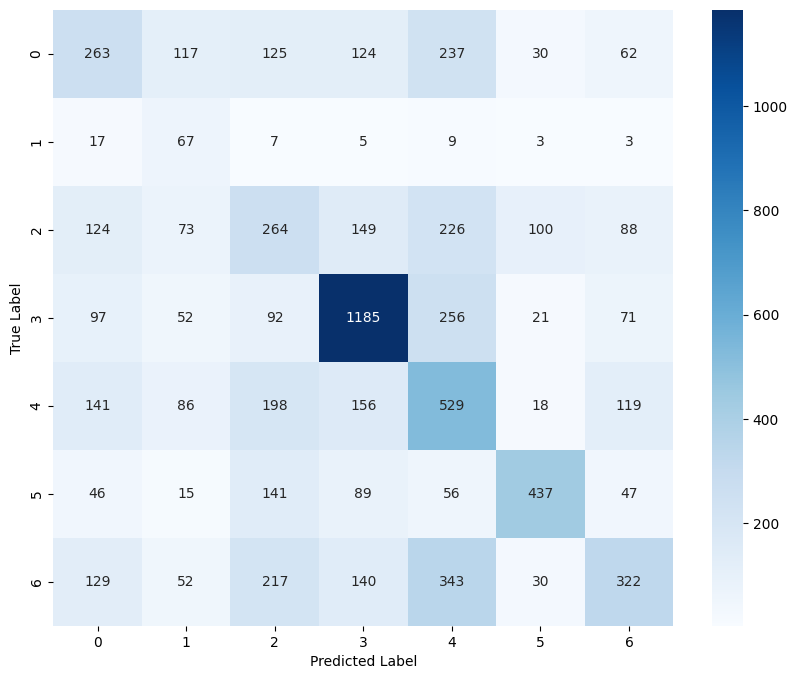

In [80]:
plot_confusion_matrix(model, test_images, test_labels)

The third column is in a dark color, indicating that for each class, most of the samples were misclassified into the "happy" class. Unfortunately, we got less satisfactory results than the results we obtained from a database that did not undergo face alignment.

# **Balancing the dataset by generating cartoon images from existing samples**



Our primary challenge with the database is the imbalance among the different categories. Our objective is to identify the most effective method to balance the data. To achieve this, we will now explore an alternative approach to SMOTE.


Our goal is to improve accuracy and achieve better results. At this stage, we are balancing the data by creating cartoon images from existing samples instead of using SMOTE. We chose this method for several reasons:

1.   Unlike SMOTE, cartoon images do not introduce noise.
2.   Unlike duplicating existing samples, this method preserves some variation
     in the samples, which is crucial for avoiding the problem of overfitting.

let's first preprocess the data

In [84]:
image_paths = train_df['image_path'].values
X = load_and_preprocess_images(image_paths)
y = train_df['label'].values

train_df = pd.DataFrame(X, columns=[f"pixel_{i}" for i in range(X.shape[1])])
train_df['label'] = y

Let's visualize an image alongside its cartoon version

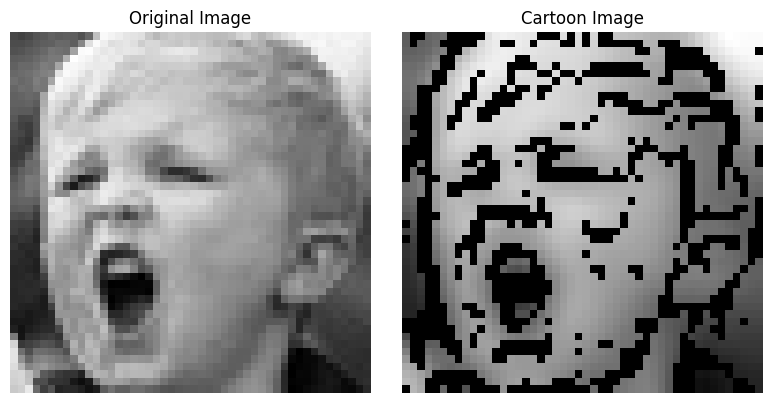

In [85]:
sample = train_df.iloc[1]
image_vector = sample.iloc[:-1]
img = np.array(image_vector).reshape((48, 48)).astype(np.uint8)

edges = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 5)
color = cv2.bilateralFilter(img, 9, 250, 250)
cartoon = cv2.bitwise_and(color, color, mask=edges)


fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(img, cmap='gray')
axs[0].axis("off")
axs[0].set_title("Original Image")

# Display the cartoon image
axs[1].imshow(cartoon, cmap='gray')
axs[1].axis("off")
axs[1].set_title("Cartoon Image")


plt.tight_layout()
plt.show()

Now we will balance the categories by generating cartoon images from existing samples

In [86]:
def get_max_samples(train_df):
    max_samples = train_df['label'].value_counts().max()
    return max_samples

def create_cartoon_samples(train_df, max_samples):
    augmented_data = []

    for category in train_df['label'].unique():
        original_samples = train_df[train_df['label'] == category]
        num_to_generate = max_samples - len(original_samples)

        if num_to_generate > 0:
            for _ in range(num_to_generate):
                sample = original_samples.sample(n=1).iloc[0]
                image_vector = sample.iloc[:-1]

                image_height = 48
                image_width = 48
                img = np.array(image_vector).reshape((image_height, image_width)).astype(np.uint8)


                edges = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 5)
                color = cv2.bilateralFilter(img, 9, 250, 250)
                cartoon = cv2.bitwise_and(color, color, mask=edges)

                cartoon_vector = cartoon.flatten()
                cartoon_sample = cartoon_vector.tolist() + [category]

                augmented_data.append(cartoon_sample)

    augmented_df = pd.DataFrame(augmented_data, columns=train_df.columns[:-1].tolist() + ['label'])
    balanced_df = pd.concat([train_df, augmented_df], ignore_index=True)

    return balanced_df

max_samples = get_max_samples(train_df)

# Create cartoon samples to balance the categories
balanced_train_df = create_cartoon_samples(train_df, max_samples)
#print(len(balanced_train_df))
balanced_train_df = balanced_train_df.sample(frac=1, random_state=0).reset_index(drop=True)




Now we will extract the features using HOG and then run the two NB and SVM algorithms

In [87]:
X1 = balanced_train_df.drop('label', axis=1).values
y1 = balanced_train_df['label'].values

In [88]:
hog_features = extract_hog_features(X1)

let's preprocess the test data :

In [89]:
X_test1 , y_test1= preprocess_test_data2(test_df)
X_test_hog1 = extract_hog_features(X_test1)

In [90]:
X_train, y_train = preprocess_train_data(balanced_train_df, pixel_columns)
X_train_rgb = np.array([convert_grayscale_to_rgb(img) for img in X_train])
train_generator = datagen.flow(X_train_rgb, y_train, batch_size=32)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# **MultinomialNB algorithm**

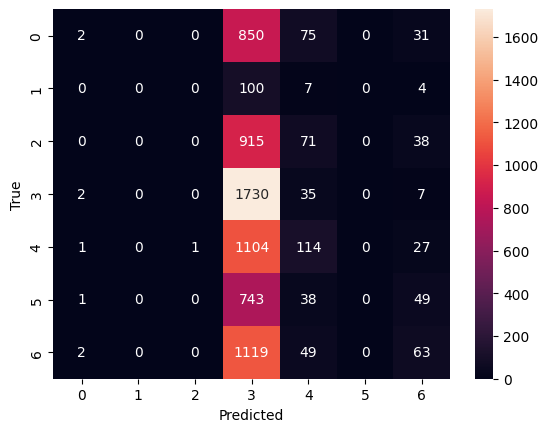

Accuracy: 0.26595151852883814


In [91]:
clf = MultinomialNB()
clf.fit(hog_features, y1)
y_pred = clf.predict(X_test_hog1)
cm = confusion_matrix(y_test1.argmax(axis=1), y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_df['label'].unique(), yticklabels=test_df['label'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print(f'Accuracy: {accuracy_score(y_test1.argmax(axis=1), y_pred)}')

It appears that using NB on the dataset balanced with SMOTE resulted in better performance (0.38) compared to balancing with cartoon images (0.26) when running NB.

# **SVM**

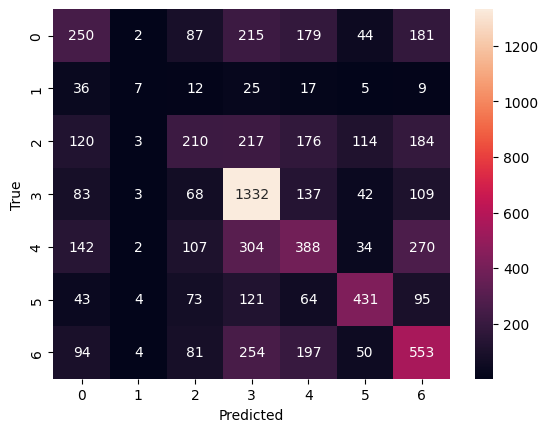

Accuracy: 0.44176650877681806


In [92]:
# Train the SVM on the HOG features
clf = svm.SVC(kernel='linear', C=1.0)
clf.fit(hog_features, y1)
y_pred = clf.predict(X_test_hog1)
cm = confusion_matrix(y_test1.argmax(axis=1), y_pred)

sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_df['label'].unique(), yticklabels=test_df['label'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(f'Accuracy: {accuracy_score(y_test1.argmax(axis=1), y_pred)}')

It seems that both using SVM on the dataset balanced with SMOTE and balancing with cartoon images resulted in the same accuracy of 0.44 -
SVM is often considered a more powerful algorithm compared to Naive Bayes ,
SVM is known for its ability to handle complex decision boundaries and high-dimensional data. It works by finding the hyperplane that best separates different classes in the feature space. This can be advantageous for our task where the relationships between features and emotions may be nonlinear

# **ResNet50**

In [93]:
model = build_and_compile_model()
history = model.fit(train_generator, epochs=5)

Epoch 1/5
1579/1579 [==============================] - 96s 42ms/step - loss: 1.5066 - accuracy: 0.4589
Epoch 2/5
1579/1579 [==============================] - 66s 42ms/step - loss: 1.1863 - accuracy: 0.5576
Epoch 3/5
1579/1579 [==============================] - 66s 42ms/step - loss: 1.1278 - accuracy: 0.5803
Epoch 4/5
1579/1579 [==============================] - 66s 42ms/step - loss: 0.9097 - accuracy: 0.6564
Epoch 5/5
1579/1579 [==============================] - 66s 42ms/step - loss: 0.8562 - accuracy: 0.6827


Our results improved compared to when we used SMOTE, achieving an accuracy of
0.75 instead of 0.68.

let's evaluate the model on the test data

In [94]:
test_images, test_labels = preprocess_test_data(test_df)

In [95]:
loss, accuracy = model.evaluate(test_images, test_labels)

print("Test Accuracy:", accuracy)

225/225 [==============================] - 3s 7ms/step - loss: 1.1987 - accuracy: 0.5527
Test Accuracy: 0.5526608824729919



We achieved an accuracy of 0.56 on the test data. This indicates that while our accuracy on the training data improved, the test data accuracy remained the same compared to the accuracy we obtained using SMOTE, leading to an increase in overfitting.

Our explanation for this phenomenon is that the samples in the current training set are more similar to each other compared to the diverse samples generated by SMOTE, where new samples are created by interpolating between several existing samples. This similarity in the training set reduces its generalizability, causing overfitting and poorer performance on the test data.

225/225 [==============================] - 2s 6ms/step


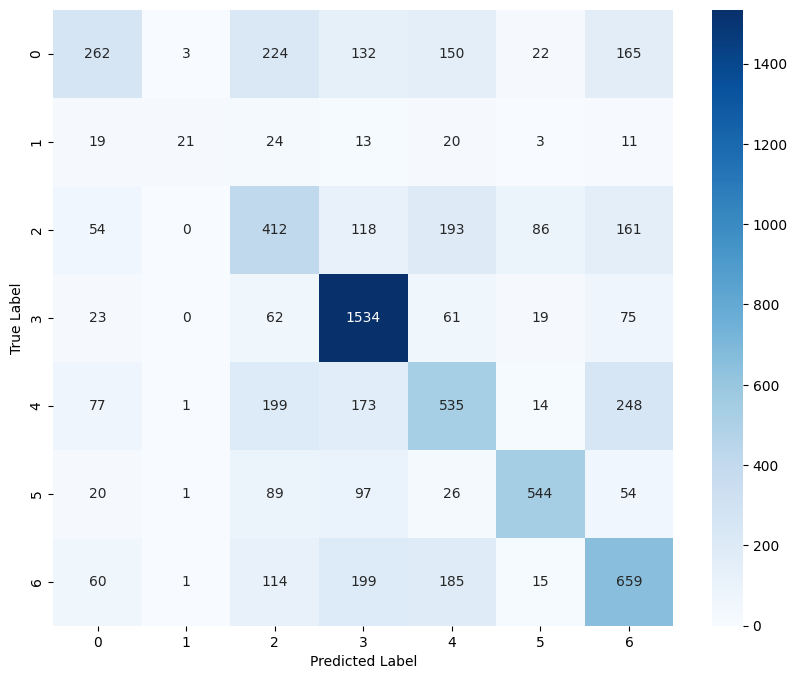

In [96]:
plot_confusion_matrix(model, test_images, test_labels)

You can see that compared to the database that went through SMOTE, the accuracy decreased in every class except for the two classes "happy" and "natural." These two classes contain the most samples in the original database, so we added fewer samples to them using the cartoon method to achieve balance. This suggests that the model trained on data that passed SMOTE has better generalization ability. The samples in the current training set are more similar to each other compared to the diverse samples generated by SMOTE, where new samples are created by interpolating between several existing samples. This similarity in the training set reduces its generalizability, causing overfitting and poorer performance on the test data.

# **Findings and Interpretation**



The times displayed in the tables represent the execution durations on A100 GPU hardware. This setup offers a substantial performance boost compared to executing the same code on a CPU.

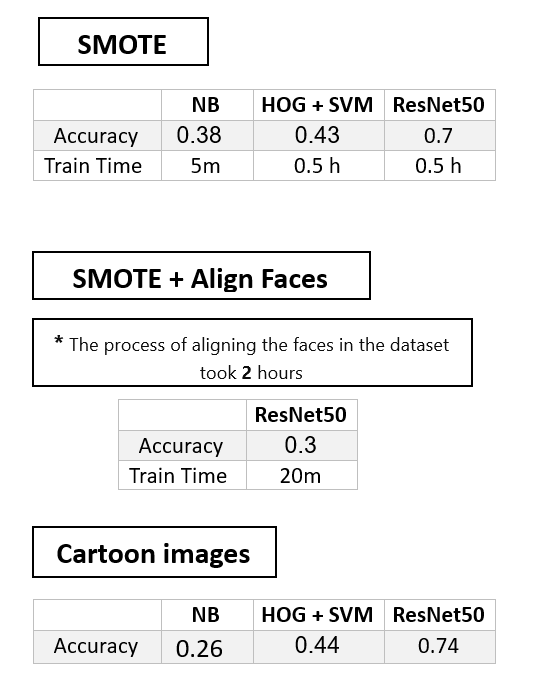

The face alignment algorithm yielded suboptimal results, resulting in a failure to align the faces accurately. We resorted to a simple and unsophisticated algorithm due to the unavailability of structured alternatives. Consequently, we refrained from running the SVM and MNB classifiers on the base post-alignment, as feature extraction using HOG proved unattainable. Our preference was to extract features using this method for a fair comparison in the end.

Notably, employing SMOTE to balance the data produced the most favorable outcomes, underscoring the significance of data variation. Balancing via cartoon image generation yielded inferior results compared to SMOTE, as previously discussed.

Moreover, it's evident that RESNET50 outperforms SVM and NB classifiers concerning the same database, underscoring the efficacy of sophisticated networks of this nature

# **Challenges**

Initially, we started working on Kaggle due to the convenience of importing databases directly. However, we faced significant issues with collaboration, as the platform did not support simultaneous editing of the notebook, leading to synchronization problems.

To address this, we switched to Google Colab, which allowed us to work concurrently on the notebook, greatly enhancing our collaborative efficiency. Nonetheless, as our project progressed, we encountered substantial limitations:

Memory Constraints: The limited memory availability on Colab hindered our ability to process larger datasets effectively.
GPU Usage Limits: The restricted time allocation for using the GPU in the free version of Colab significantly impeded our progress. Some algorithms required extensive computational resources and took more than 6 hours to run on a CPU, which was impractical for our needs.
To overcome these obstacles, we opted to upgrade to Colab Pro+, which provided us with unlimited GPU access. This upgrade was essential for maintaining our workflow's efficiency and ensuring that our computational needs were met without interruptions.

# **Improvement ideas**



1.   Train a facial alignment model ourselves based on a labeled database and then use the algorithm we built.


2.   Try to balance the data by merging several databases.



# **Self reflection**

We thoroughly enjoyed working on this project. It was both challenging and rewarding to learn new algorithms and fill in the gaps in our knowledge to accomplish the required tasks. Throughout the process, we encountered numerous ideas, some of which proved to be successful and were included in the final project, while others did not work out and were subsequently excluded.

We found the journey engaging, particularly the trial-and-error approach, as it allowed us to explore what worked and what needed to be changed. At each stage, we held specific views and, after completing each phase, we analyzed why we believed it worked or did not. This iterative process was crucial in refining our understanding and improving our results.

Additionally, we experienced firsthand the importance of advanced hardware and the efficiency of existing libraries. Without these resources, the algorithms took an unreasonable amount of time to execute, and we occasionally faced seemingly insurmountable obstacles. This highlighted the critical role that hardware and software optimization play in the successful implementation of complex algorithms.









---

# **:):**
  *It's about how you choose to look at it, or about which emotion recognition algorithm you use*


---



# **Thank you for the opportunity to explore the world of Data Science :)**